# resnet34

In [1]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import os
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from torchinfo import summary
import torchvision.models as models

C:\ProgramData\anaconda3\envs\Torch_PY38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


# 이미지 전처리 및 dataset 생성

In [2]:
preprocessing = transforms.Compose([
    transforms.Resize(size = (150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

In [3]:
file_dir = './image'
imgDS = ImageFolder(root = file_dir, transform = preprocessing)

In [4]:
# print(imgDS.classes, imgDS.class_to_idx)

In [5]:
# imgDS.imgs[:5]

In [6]:
# print(type(imgDS))

In [7]:
# count = 1
# for img, label in imgDS:
#     # print(label)
#     if label == 1:
#         break
#     count += 1
# print(count)
# # chicken : 0 (200)   poodle :  (190)

In [8]:
# dataset에서 train, valid, test를 나누어보자
seed_gen = torch.Generator().manual_seed(42)
tr, val, ts = 0.7,0.1,0.2
trainDS, validDS, testDS = random_split(imgDS, [tr, val, ts], generator=seed_gen)
# print(len(trainDS), len(validDS), len(testDS))

# dataloader 생성

In [9]:
# 각 분류별로 dataloader를 생성해보자
batch_size = 10
train_dl = DataLoader(trainDS, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(validDS, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(testDS, batch_size = batch_size, shuffle=True)
# print(len(train_dl), len(valid_dl), len(test_dl))

In [10]:
# chicken_dl = DataLoader(dataset = imgDS)
# for (image, label) in chicken_dl:
#         print(image.shape, label)

# 전이학습 기릿

In [11]:
# 모델 인스턴스 생성 : 사전 학습된 모델 로딩 
# => 가중치를 조절해보자!
res_model = models.resnet34(weights = "ResNet34_Weights.DEFAULT")

# 전결합층 변경
res_model.fc = nn.Linear(in_features = 512, out_features = 1)

In [12]:
# res_model

In [13]:
# summary(res_model, input_size = (1, 3, 150, 150))

In [14]:
# 모델의 합성곱층 가중치 고정
for param in res_model.parameters(): 
    param.requires_grad = False
for param in res_model.fc.parameters():   # 완전 연결층은 학습
    param.requires_grad = True

# print(res_model)

# 학습, 검증, 테스트 함수 정의

In [15]:
optimizer = torch.optim.Adam(res_model.fc.parameters(), lr=0.01)
cost = torch.nn.BCELoss() # 손실함수 정의

In [16]:
import torchmetrics.functional as metrics

def training(dataloader):
    res_model.train()
    loss_list = []
    acc_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    for image, label in dataloader:
        # 학습
        pre_label = res_model(image)
        pre_label = F.sigmoid(pre_label)
        pre_label = pre_label.squeeze()
        # print(label.shape, pre_label.shape)
        # print(label, pre_label, sep = '\n\n')
        
        # 손실계산
        train_loss = cost(pre_label, label.float())
        # train_loss = cost(pre_label, label)
        
        # w,b 업데이트
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        
        # 정확도
        acc = metrics.accuracy(pre_label, label, task = 'binary') 
        precision = metrics.precision(pre_label, label, task = 'binary')
        recall = metrics.recall(pre_label, label, task = 'binary')
        f1score = metrics.f1_score(pre_label, label, task = 'binary')
        
        loss_list.append(train_loss)
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
    total_loss = sum(loss_list) / len(loss_list)
    total_acc = sum(acc_list) / len(acc_list)
    total_precision = sum(precision_list) / len(precision_list)
    total_recall = sum(recall_list)/len(recall_list)
    total_f1score = sum(f1score_list) / len(f1score_list)
    # print(f"[TOTAL Train Loss] ==> {total_loss}")
    # print(f"ACC : {total_acc}  Precision : {total_precision}  Recall : {total_recall} F1score : {total_f1score}")
    return total_loss, total_acc, total_precision, total_recall, total_f1score

# training(train_dl)

In [17]:
def valid_testing(dataloader):
    res_model.eval()
    loss_list = []
    acc_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    for image, label in dataloader:
        # 학습
        pre_label = res_model(image)
        pre_label = F.sigmoid(pre_label)

        pre_label = pre_label.squeeze()
        # print(label.shape, pre_label.shape)
        # print(label, pre_label, sep = '\n\n')
        
        # 손실계산
        valid_loss = cost(pre_label, label.float())
        # train_loss = cost(pre_label, label)
        
        # 정확도
        acc = metrics.accuracy(pre_label, label, task = 'binary') 
        precision = metrics.precision(pre_label, label, task = 'binary')
        recall = metrics.recall(pre_label, label, task = 'binary')
        f1score = metrics.f1_score(pre_label, label, task = 'binary')
        loss_list.append(valid_loss)
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
    total_loss = sum(loss_list) / len(loss_list)
    total_acc = sum(acc_list) / len(acc_list)
    total_precision = sum(precision_list) / len(precision_list)
    total_recall = sum(recall_list)/len(recall_list)
    total_f1score = sum(f1score_list) / len(f1score_list)
    # print(f"[TOTAL Train Loss] ==> {total_loss}")
    # print(f"ACC : {total_acc}  Precision : {total_precision}  Recall : {total_recall} F1score : {total_f1score}")
    return total_loss, total_acc, total_precision, total_recall, total_f1score

# valid_testing(valid_dl)

# 학습 진행해보자

In [18]:
## 학습 중 모델 저장 관련 변수
dir = './model/'
filename = dir + "best_model.pth"

import os
if not os.path.exists(dir) :
    os.mkdir(dir)       # 하위 폴더만 생성 증, data 폴더는 이미 존재해야 함
    # os.makedirs(dir)    # 존재하지 않는 상위 폴더부터 생성

In [19]:
epoch_num = 20
training_list = [[], [], [], [], []]
validing_list = [[], [], [], [], []]
# loss, acc, prec, rec, f1_score
scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones = [0, epoch_num], gamma = 0.5)
# milestones => 어떤 에포크 구간에서 학습률을 조정할지 나타내는거

# 모델 저장 관련 변수
save_score_point = 5

In [20]:
for epo in range(epoch_num):
    # 학습
    loss, acc, prec, rec, f1 = training(train_dl)
    print(loss, acc, prec, rec, f1)
    training_list[0].append(loss.item())
    training_list[1].append(acc.item())
    training_list[2].append(prec.item())
    training_list[3].append(rec.item())
    training_list[4].append(f1.item())
    print(f"epo => {epo}  학습중")
    # 검증
    loss, acc, prec, rec, f1 = valid_testing(valid_dl)
    validing_list[0].append(loss.item())
    validing_list[1].append(acc.item())
    validing_list[2].append(prec.item())
    validing_list[3].append(rec.item())
    validing_list[4].append(f1.item())
    print(f"epo => {epo}  검증중")
    
    # 검증 데이터 기준 학습된 모델 저장
    if loss < save_score_point:
        torch.save(res_model, filename)
        print('  모 델 저 장 완 료\n')
    
    # 스케줄러
    scheduler.step()

C:\ProgramData\anaconda3\envs\Torch_PY38\lib\site-packages\PIL\Image.py:981: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


tensor(0.2414, grad_fn=<DivBackward0>) tensor(0.9105) tensor(0.9348) tensor(0.9426) tensor(0.9205)
epo => 0  학습중
epo => 0  검증중
  모 델 저 장 완 료
tensor(0.1228, grad_fn=<DivBackward0>) tensor(0.9352) tensor(0.9500) tensor(0.9545) tensor(0.9389)
epo => 1  학습중
epo => 1  검증중
  모 델 저 장 완 료
tensor(0.1197, grad_fn=<DivBackward0>) tensor(0.9571) tensor(0.9520) tensor(0.9695) tensor(0.9518)
epo => 2  학습중
epo => 2  검증중
  모 델 저 장 완 료
tensor(0.1988, grad_fn=<DivBackward0>) tensor(0.9229) tensor(0.9260) tensor(0.9607) tensor(0.9151)
epo => 3  학습중
epo => 3  검증중
  모 델 저 장 완 료
tensor(0.0892, grad_fn=<DivBackward0>) tensor(0.9714) tensor(0.9610) tensor(0.9824) tensor(0.9674)
epo => 4  학습중
epo => 4  검증중
  모 델 저 장 완 료
tensor(0.0892, grad_fn=<DivBackward0>) tensor(0.9657) tensor(0.9729) tensor(0.9668) tensor(0.9624)
epo => 5  학습중
epo => 5  검증중
  모 델 저 장 완 료
tensor(0.0414, grad_fn=<DivBackward0>) tensor(0.9857) tensor(0.9871) tensor(0.9878) tensor(0.9858)
epo => 6  학습중
epo => 6  검증중
  모 델 저 장 완 료
tensor(0.0497

In [21]:
epo_list = list(range(0, epoch_num))
# print(epo_list)
title_list = ['LOSS', 'ACC', 'PRECISION', 'RECALL', 'F1-SCORE']

In [22]:
for k in range(5):
    print(sum(training_list[k]) / len(training_list[k]))
    

0.10828859414905309
0.9588095098733902
0.9584625750780106
0.970398536324501
0.9551964491605759


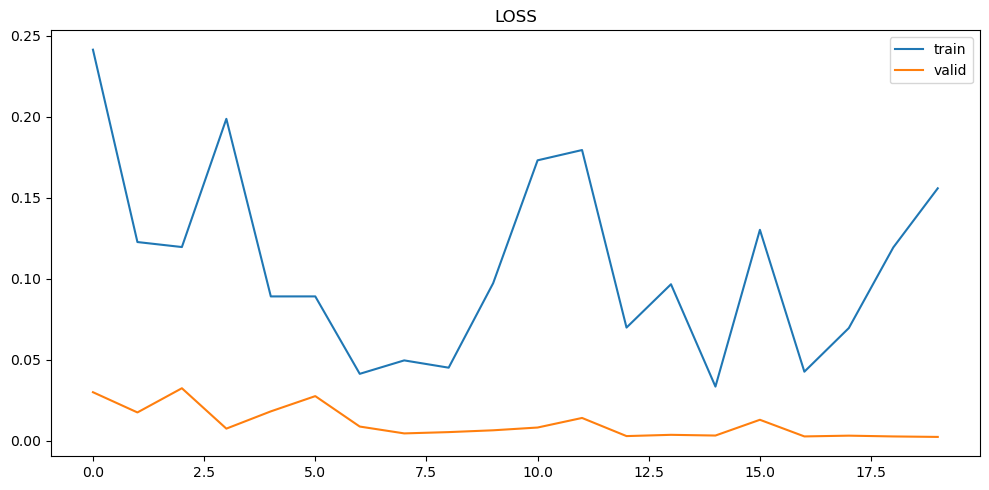

In [23]:
plt.figure(figsize = (10,5))
k=0
plt.title(title_list[k])
plt.plot(epo_list, training_list[k], label = 'train')
plt.plot(epo_list, validing_list[k], label = 'valid')
plt.legend()
plt.tight_layout()
plt.show()

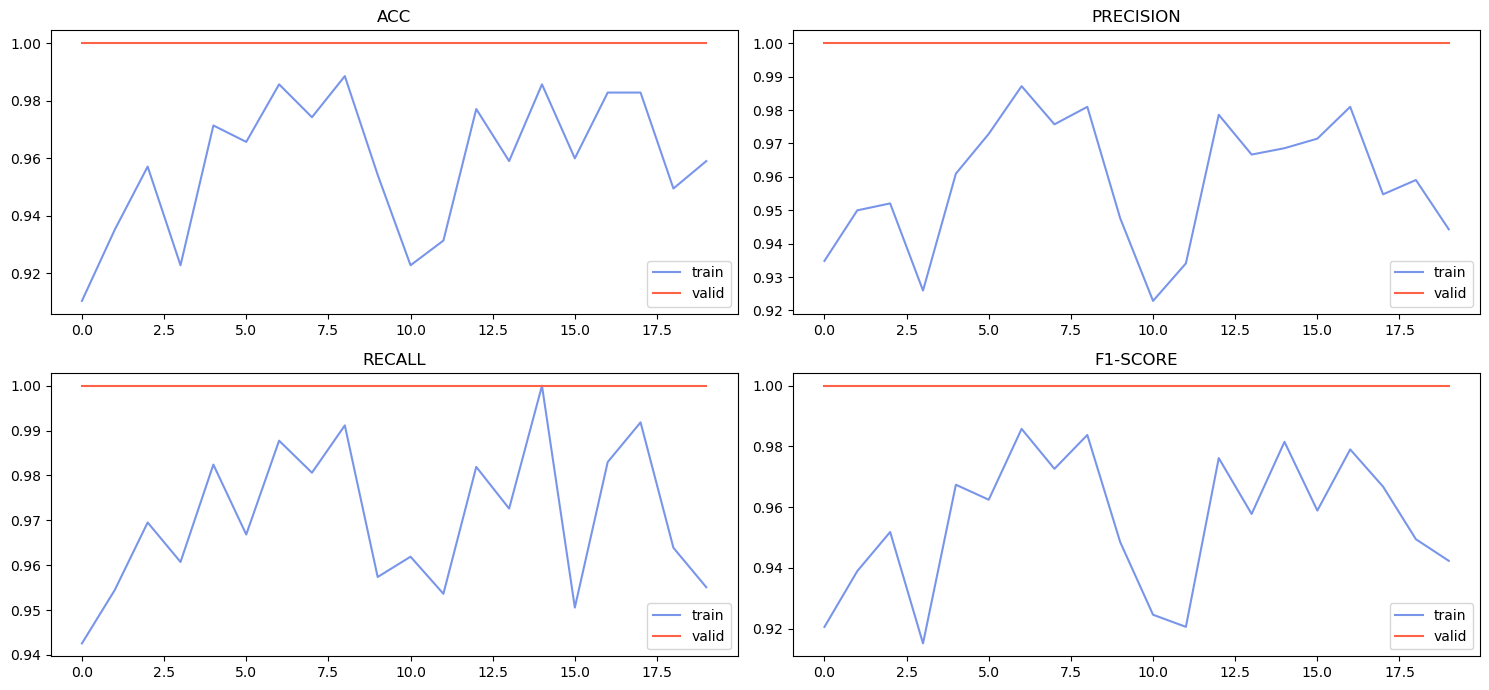

In [24]:
plt.figure(figsize = (15,7))
for k in range(1,5):
    plt.subplot(2,2,k)
    plt.title(title_list[k])
    plt.plot(epo_list, training_list[k], label = 'train', color = 'royalblue', alpha = 0.7)
    plt.plot(epo_list, validing_list[k], label = 'valid', color = 'tomato')
    plt.legend()
plt.tight_layout()
plt.show()

# 예측

In [25]:
def predicting(dataloader):
    res_model.eval()
    loss_list = []
    acc_list = []
    precision_list = []
    recall_list = []
    f1score_list = []
    for image, label in dataloader:
        # 학습
        pre_label = res_model(image)
        pre_label = F.sigmoid(pre_label)
        pre_label = pre_label.squeeze()
        
        # 손실계산
        pred_loss = cost(pre_label, label.float())
        
        # 정확도
        acc = metrics.accuracy(pre_label, label, task = 'binary') 
        precision = metrics.precision(pre_label, label, task = 'binary')
        recall = metrics.recall(pre_label, label, task = 'binary')
        f1score = metrics.f1_score(pre_label, label, task = 'binary')
        
        
        loss_list.append(pred_loss)
        acc_list.append(acc)
        precision_list.append(precision)
        recall_list.append(recall)
        f1score_list.append(f1score)
    total_loss = sum(loss_list) / len(loss_list)
    total_acc = sum(acc_list) / len(acc_list)
    total_precision = sum(precision_list) / len(precision_list)
    total_recall = sum(recall_list)/len(recall_list)
    total_f1score = sum(f1score_list) / len(f1score_list)
    print(f"[TOTAL Train Loss] ==> {total_loss}")
    print(f"ACC : {total_acc}  Precision : {total_precision}  Recall : {total_recall} F1score : {total_f1score}")
    return total_loss, total_acc, total_precision, total_recall, total_f1score

predicting(test_dl)

[TOTAL Train Loss] ==> 0.004775066860020161
ACC : 1.0  Precision : 1.0  Recall : 1.0 F1score : 1.0


(tensor(0.0048, grad_fn=<DivBackward0>),
 tensor(1.),
 tensor(1.),
 tensor(1.),
 tensor(1.))